# Model showcase
Model showcase for the classification task of temperature being above a certain quantile threshold
* Chosen hybrid model: bootstrapped skill as a function of threshold/timeagg/separation
* Chosen hybrid model: reliability diagrams
* Timeserie properties, ways to deal with climate trend
* Skill of the alternative previous models

In [3]:
import sys
import os
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

from pathlib import Path
from scipy.signal import detrend
from sklearn.metrics import brier_score_loss, log_loss
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from statsmodels.nonparametric.smoothers_lowess import lowess

sys.path.append(os.path.expanduser('~/Documents/Weave'))
from Weave.models import fit_predict, fit_predict_evaluate, evaluate, hyperparam_evaluation, map_foldindex_to_groupedorder, BaseExceedenceModel, HybridExceedenceModel
from Weave.utils import brier_score_clim, reliability_plot

In [4]:
basedir = Path('/nobackup_1/users/straaten/')
#basedir = Path('/scistor/ivm/jsn295/')
# Latest:
skillpath = basedir / 'bootstrap_hybrid_noncv_base_noncv/fit_base_to_all_cv=True.max_depth=5.n_estimators=2500.min_samples_split=30.max_features=35.n_jobs=19.bs.parquet' # Base logistic regression fitted to the full (non-cv) dataset, as is the reference model
skillpath_base = basedir / 'bootstrap_base/BaseExceedenceModel.bs.parquet' # Only the logistic regression
# Alternatives
skillpath_hybrid = basedir / 'hybrid_old/bootstrap_hybrid_base/max_depth=5.n_estimators=2500.min_samples_split=30.max_features=35.n_jobs=19.bs.parquet' # Latest but base and reference (!) fitted to part of the data
skillpath_hybrid_strict = basedir / 'hybrid_old/bootstrap_hybrid_base_noncv/max_depth=5.n_estimators=2500.min_samples_split=30.max_features=35.n_jobs=19.bs.parquet' # Latest but base fitted to part of the data and reference to full
skillpath_bs = basedir / 'hybrid_old/bootstrap_hybrid/max_depth=5.n_estimators=2500.min_samples_split=30.max_features=35.n_jobs=19.bs.parquet' # Relative to fixed climatology (inflated due to trend)
skillpath_parcor = basedir / 'non_hybrid/bootstrap_full/max_depth=7.n_estimators=1500.min_samples_split=40.max_features=35.n_jobs=7.bs.parquet' # Old linear detrended classifier skill, with partial correlation patterns as input
skillpath_normcor = basedir / 'non_hybrid/bootstrap_normcor/max_depth=5.n_estimators=2500.min_samples_split=30.max_features=35.n_jobs=19.bs.parquet' # Old linear detrended classifier skill, with normal correlation patterns as input

inputpath = basedir / 'clusters_cv_spearmanpar_varalpha_strict' # Latest dimreduced X and y data 

## Bootstrapped skill

In [5]:
def transform_to_skill(dataframe):
    """
    Handles two occasions to add BSS columns to the frame. 
    Either a fixed climatology was appended
    Or another type of reference was used within bootstrapping (and 'bs' was already 'bss')
    """
    for quantile in ['0.05','0.5','0.95']:
        if 'clim' in dataframe.columns:
            dataframe[f'{quantile}_skill'] = 1 - dataframe[quantile] / dataframe['clim']
        else:
            dataframe[f'{quantile}_skill'] = dataframe[float(quantile)] # Float indexed (not mixed with the str of 'clim')
    return dataframe

def skill_plot(df, respaggs: list = None, thresholds: list = None, blocksizes: list = None):
    """
    Plots the bootstrapped BSS bounds (0.05 and 0.95) for different block sizes
    each panel shows the skill as a function of separation / (gapsize) 
    for a single repsonse aggregation and threshold.
    """
    if respaggs is None:
        respaggs = df.index.get_level_values('timeagg').unique().sort_values()
    if thresholds is None:
        thresholds = df.index.get_level_values('threshold').unique().sort_values()
    if blocksizes is None:
        blocksizes = df.index.get_level_values('blocksize').unique() # Can contain nan, meaning blocksize=1 and normal bootstrapping
    cmap=plt.get_cmap('Blues')
    cmaplist = [cmap(int(i)) for i in np.linspace(50, cmap.N-30, num = len(blocksizes))]
    
    fig,axes = plt.subplots(ncols = len(respaggs), nrows = len(thresholds), squeeze = False, sharey=True, sharex = True, figsize = (3*len(respaggs),2.5*len(thresholds)))
    fig.patch.set_facecolor('white')
    for i, threshold in enumerate(thresholds):
        for j, respagg in enumerate(respaggs[::-1]):
            ax = axes[i,j]
            ax.set_prop_cycle(color = cmaplist)
            for blocksize in blocksizes[::-1]:
                selection = df.loc[(respagg,slice(None),threshold,blocksize),['0.05_skill','0.95_skill']]
                ax.fill_between(x = selection.index.get_level_values('separation'), y1 = selection['0.05_skill'], y2 = selection['0.95_skill'], label = str(int(blocksize)) if not np.isnan(blocksize) else '1')
            ax.hlines(y = 0, xmin = df.index.get_level_values('separation').min(), xmax = df.index.get_level_values('separation').max(),label = 'clim', color = 'crimson')
            ax.set_title(f'threshold {threshold}, respagg {respagg}')
            if j == 0:
                ax.set_ylabel('brier skill score')
            if i == len(thresholds) - 1:
                ax.set_xlabel('separation [days]')
            
    axes[-1,0].legend(title = 'blocksize', loc = 'upper left')
    return fig, axes

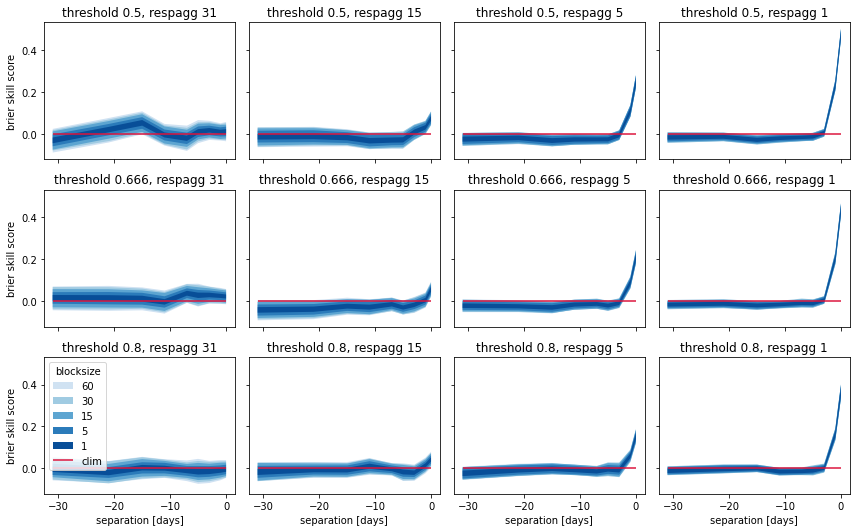

In [49]:
frame = pd.read_parquet(skillpath)
frame = transform_to_skill(frame)
fig, axes = skill_plot(frame, respaggs = [1,5,15,31], thresholds = [0.5,0.666,0.8])
plt.tight_layout()
plt.show()

General trends here are:
* More uncertainty in the score for larger response aggregations and more extremes (0.9 not even shown) increasing blocksize to the maximum has most effect for the largest aggregation (less independent data).
* Curvature becomes steeper for smaller reponse aggregations. But the sudden entering into 'skillful' area is less present for the extremes. The absence of curving for the largest aggregations has nothing to do with the quality of precursor information. It is the same. Conceptually it could be that there is less of a relation (teleconnection or feedback) to be used. These could take to long, and persistence cannot make up for it?
* At large separations the small response aggregations are just quite unpredictable. Meaning that predicting the 31 day stuff is not because of succesful prediction of the first 15 days, or 7 or less days.

We can compare this latest model (that is relative to the trend model with time-dependent probability) to an older non-hybrid version that dealt with the classification problem in detrended space. It is therefore relative to the a fixed climatological probability. Uncertainty is certainly larger. Shapes are comparable. Which is contrary to what I first thought. I believed that the additive approach made it all steeper.

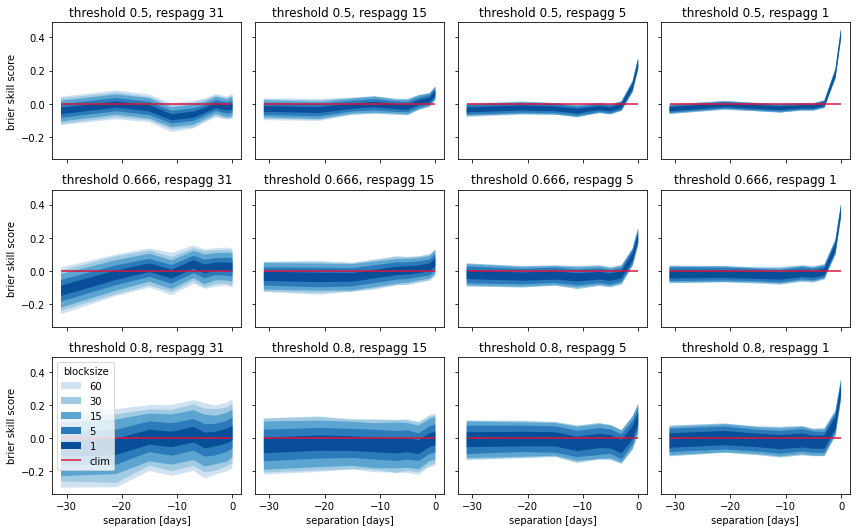

In [50]:
frame = pd.read_parquet(skillpath_parcor)
frame = transform_to_skill(frame)
fig, axes = skill_plot(frame, respaggs = [1,5,15,31], thresholds = [0.5,0.666,0.8])
plt.tight_layout()
plt.show()

## Reliability of the chosen approach
The BSS paint a discouraging picture for empirical long-lead predictability of Northwest-Europe summer temperature. Reliability diagrams are more promising. Investigate the finding that not all improvement upon the base trend model is shown by BSS. Also to compare thresholds and response aggregations among each other. Hypotheses:
* More resolution with decreasing separation as you get closer to the event
* Predictability of large timescale not within the first few days
* Extremes are hard, but also bulk of the distribution has low signal/noise. Intermediate thresholds are most predictable

Conclusions:
* Seems true for the response timescales with most 'curve', but in a non-linear fashion. Not true for the large respaggs.
* Seems to be the case.
* Unconclusive

In [15]:
def read_data(responseagg = 3, separation = -7, trended = False, quantile = 0.8):
    """
    Returns the selcted X and y data
    A dataframe and a (de)trended Series
    """
    if trended:
        Y_path = inputpath / 'response.multiagg.trended.parquet'
    else:
        Y_path = inputpath / 'response.multiagg.detrended.parquet'
    X_path = inputpath / 'precursor.multiagg.parquet'
    y = pd.read_parquet(Y_path).loc[:,(slice(None),responseagg,slice(None))].iloc[:,0] # Only summer
    X = pd.read_parquet(X_path).loc[y.index,(slice(None),slice(None),slice(None),slice(None),separation,slice(None),slice(None))].dropna(axis = 0, how = 'any') # both metrics
    y = y.reindex(X.index)
    y = y > y.quantile(quantile)
    map_foldindex_to_groupedorder(X = X, n_folds = 5)
    return X, y

def get_predictions(model, respaggs: list, thresholds: list, separations: list, trended: bool = True):
    """
    For the requested models (unique combinations of respagg, threshold, separation)
    It gets the 5-fold cv fit and predict (some randomness involved here)
    Returns a dataframe of the made predictions, and the response.
    If multiple thresholds or respaggs are requested it needs to also
    return different versions of y. Therefore these are also stored and returned
    """
    results = []
    ys = []
    for respagg, separation, threshold in itertools.product(respaggs, separations, thresholds):
        X, y = read_data(respagg, separation, trended = trended, quantile = threshold)
        preds = fit_predict(model, X, y, n_folds = 5, split_on_year = True)
        preds = preds.to_frame()
        preds.columns = pd.MultiIndex.from_tuples([(respagg,separation,threshold)],names = ['respagg','separation','threshold'])
        results.append(preds)
        y = y.to_frame()
        y.columns = pd.MultiIndex.from_tuples([(respagg,threshold)], names = ['respagg','threshold'])
        ys.append(y)
    results = pd.concat(results, axis = 1).sort_index(axis = 1)
    ys = pd.concat(ys, axis = 1).sort_index(axis = 1)
    ys = ys.loc[:,~ys.columns.duplicated()] # removing duplicates and if only one is left return as series (preferred for the reliability plot)
    if len(ys.columns) == 1:
        ys = ys.iloc[:,0] # collapses to series
    return ys, results
    
def strip_for_reliability(frame):
    """
    Reliability plots are clearest when only one aspect (respagg, separation, threshold) changes
    This strips the non-changing aspects and returns those for the plot title.
    """
    frame = frame.copy()
    cols = pd.DataFrame({'values':[frame.columns.get_level_values(key).unique().values for key in frame.columns.names]}, index = frame.columns.names)
    cols['length'] = cols['values'].map(lambda vals: len(vals))
    cols['repr'] = cols['values'].map(lambda vals: float(vals) if len(vals) == 1 else '...')
    n_non_unique = sum(cols['length'] > 1)
    assert n_non_unique <= 1, f'Only one level of {frame.columns.names} can be non-unique'
    frame.index = frame.index.droplevel('fold')
    if n_non_unique > 0:
        frame.columns = frame.columns.droplevel(cols.loc[cols['length'] == 1].index.tolist())
    return frame, f'{cols.loc["respagg","repr"]}day > q{cols.loc["threshold","repr"]}, at {cols.loc["separation","repr"]}'

In [16]:
model = HybridExceedenceModel(fit_base_to_all_cv = True, base_only = False, n_jobs = 8, max_depth = 5, min_samples_split = 30, n_estimators = 2500, max_features = 35)
basemodel = HybridExceedenceModel(fit_base_to_all_cv = True, base_only = True)

### First hypothesis

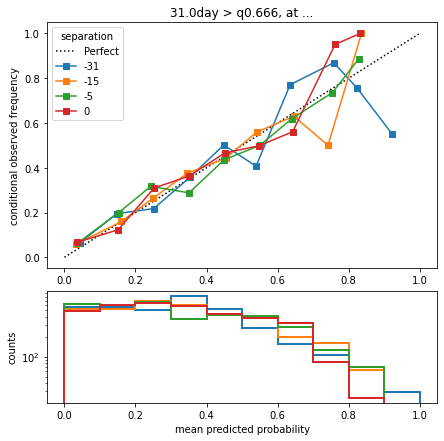

In [8]:
y_true, y_probs = get_predictions(model, respaggs = [31],thresholds = [0.666], separations = [-31,-15,-5,0])
fr, tit = strip_for_reliability(y_probs)
fig, axes = reliability_plot(y_true=y_true, y_probs = fr)
axes[0].set_title(tit)
plt.show()

There's not that much of a resolution difference the close you get to the event for large response aggregations. It does seem to get a bit more reliable though. How does this compare to the base model? Which is not dependent on separation.

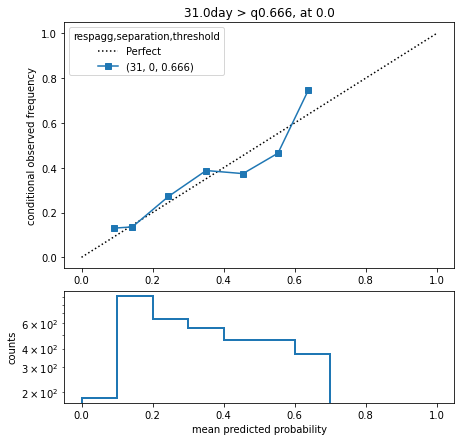

In [18]:
y_true, y_probs = get_predictions(basemodel, respaggs = [31],thresholds = [0.666], separations = [0])
fr, tit = strip_for_reliability(y_probs)
fig, axes = reliability_plot(y_true=y_true, y_probs = fr)
axes[0].set_title(tit)
plt.show()

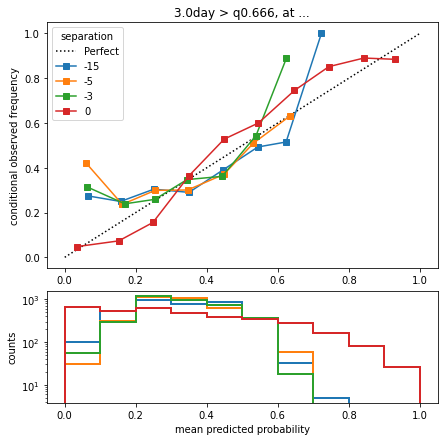

In [19]:
y_true, y_probs = get_predictions(model, respaggs = [3],thresholds = [0.666], separations = [-15,-5,-3,0])
fr, tit = strip_for_reliability(y_probs)
fig, axes = reliability_plot(y_true=y_true, y_probs = fr)
axes[0].set_title(tit)
plt.show()

The increase of resolution for a short response aggregation does not seem to behave linearly. With respagg = 3 you indeed see the biggest resolution at separation 0. 15 is not good but better (in terms of underforecasting no chance of the event) than the intermediate separations. 

### Second hypothesis

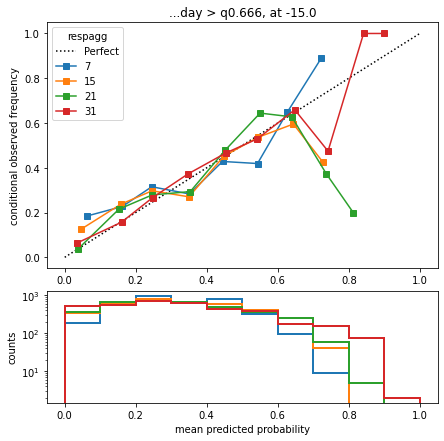

In [20]:
y_true, y_probs = get_predictions(model, respaggs = [31,21,15,7], thresholds = [0.666], separations = [-15])
fr, tit = strip_for_reliability(y_probs)
fig, axes = reliability_plot(y_true=y_true, y_probs = fr)
axes[0].set_title(tit)
plt.show()

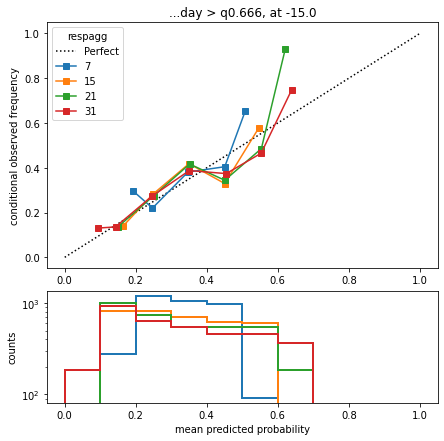

In [21]:
y_true, y_probs = get_predictions(basemodel, respaggs = [31,21,15,7], thresholds = [0.666], separations = [-15])
fr, tit = strip_for_reliability(y_probs)
fig, axes = reliability_plot(y_true=y_true, y_probs = fr)
axes[0].set_title(tit)
plt.show()

Here one really needs to view both the base model and the hybrid at the same time. Base has some resolution for all, with increasing resolution (i.e. presence of a climate trend signal) for the larger response aggregations. What you then see is that the hybrid add resolution on top of that for all... But that it has the easiest task in reliabily extending downward and upward (in probability terms) for the 31 aggregation. This source of this predictable relation thus does not lie at the shorter timescales (as all are given same input, belonging to this separation)

### Third hypothesis

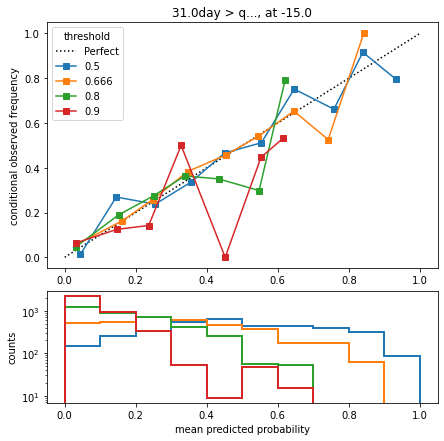

In [22]:
y_true, y_probs = get_predictions(model, respaggs = [31], thresholds = [0.5,0.666,0.8,0.9], separations = [-15])
fr, tit = strip_for_reliability(y_probs)
fig, axes = reliability_plot(y_true=y_true, y_probs = fr)
axes[0].set_title(tit)
plt.show()

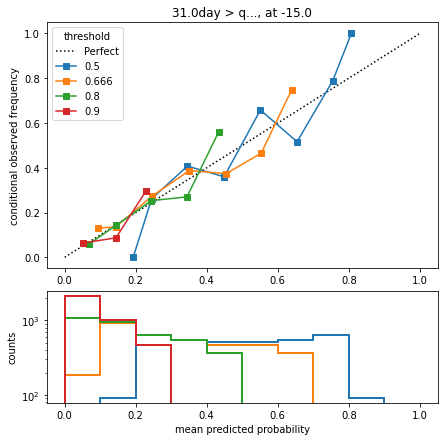

In [23]:
y_true, y_probs = get_predictions(basemodel, respaggs = [31], thresholds = [0.5,0.666,0.8,0.9], separations = [-15])
fr, tit = strip_for_reliability(y_probs)
fig, axes = reliability_plot(y_true=y_true, y_probs = fr)
axes[0].set_title(tit)
plt.show()

We cannot really reach a conclusion here. From the basemodels it is apparent that for all quantiles there is some trend to be exploited. Relative to that the model at 0.5 and 0.666 seem reliable resolution extenders. Which is somewhat visible in the bootstrapped BSS plots (normalized just lower for the extremes). And you would conclude that the more extreme the harder (no optimum). But then the probability jump made by the model on top of the trend is largest for the largest threshold. This has been trained on something so even though unreliably learned, a potential seems to exist. This is a more certain forecasting situation (0 days in between):

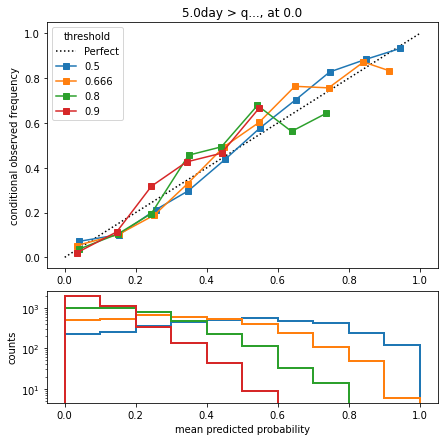

In [25]:
y_true, y_probs = get_predictions(model, respaggs = [5], thresholds = [0.5,0.666,0.8,0.9], separations = [0])
fr, tit = strip_for_reliability(y_probs)
fig, axes = reliability_plot(y_true=y_true, y_probs = fr)
axes[0].set_title(tit)
plt.show()

## Response trends and previous alternative models
The old approach was to linearly detrend the temperature anomaly timeseries. On that detrended timeseries the quantile threshold was computed.

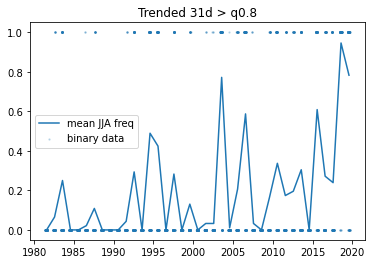

In [54]:
X, y = read_data(responseagg = 31, trended = True, quantile = 0.8)
mean_freq = y.groupby(y.index.year).mean()
mean_freq.index = pd.date_range('1981',periods = len(mean_freq), freq = 'A-JUL' )
fig, ax = plt.subplots()
ax.scatter(x = y.index, y = y, s = 2, alpha = 0.2, label = 'binary data')
ax.plot(mean_freq, label = 'mean JJA freq')
ax.legend(loc = 'center left')
ax.set_title('Trended 31d > q0.8')
plt.show()

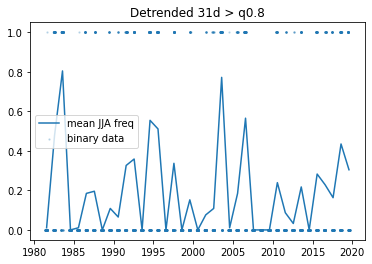

In [55]:
X, y = read_data(responseagg = 31, trended = False, quantile = 0.8)
mean_freq = y.groupby(y.index.year).mean()
mean_freq.index = pd.date_range('1981',periods = len(mean_freq), freq = 'A-JUL' )
fig, ax = plt.subplots()
ax.scatter(x = y.index, y = y, s = 2, alpha = 0.2, label = 'binary data')
ax.plot(mean_freq, label = 'mean JJA freq')
ax.legend(loc = 'center left')
ax.set_title('Detrended 31d > q0.8')
plt.show()

Different distribution of the positive class over time. Looking at the trended data you see that absolute events were rare further back. Something exceptional might have happened that is different from the more common mechanisms now. It therefore is weird to get an overrepresentation of those past events in the mixture of the positive class that is supposed to be homogeneous.

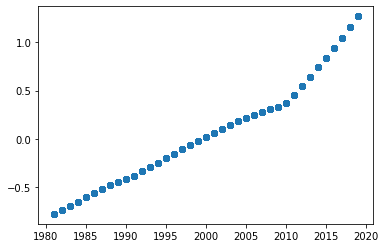

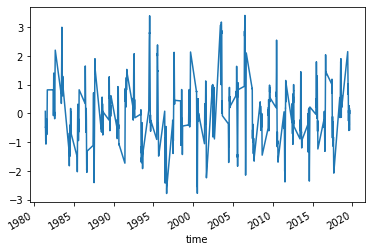

In [3]:
test = lowess(y_tr,y_tr.index.year, it = 1, frac = 0.5)
plt.scatter(x = test[:,0], y = test[:,1])
plt.show()
y_new = y_tr - test[:,1]
y_new.plot()

In [24]:
y_new = y_new > y_new.quantile(threshold)
y_tr = y_tr > y_tr.quantile(threshold)
y = y > y.quantile(threshold)

In [25]:
evaluate_kwds = dict(scores = [brier_score_loss], score_names = ['bs'])
m = RandomForestClassifier(n_estimators=1500, n_jobs=15, min_samples_split=40, max_depth=7, max_features = 35)

In [10]:
preds = fit_predict(model = m, X_in = X, y_in = y_new, n_folds = 5)
preds.index = preds.index.droplevel('fold')
ret = evaluate(y_true = y_new, y_pred=preds, **evaluate_kwds)

In [11]:
ret

score
bs    0.225524
dtype: float64

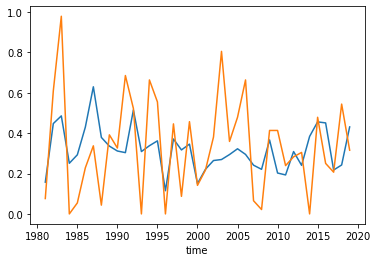

In [12]:
preds.groupby(preds.index.year).mean().plot()
y_new.groupby(y_new.index.year).mean().plot()

In [13]:
preds2 = fit_predict(model = m, X_in = X, y_in = y, n_folds = 5)
preds2.index = preds2.index.droplevel('fold')
ret2 = evaluate(y_true = y, y_pred=preds2, **evaluate_kwds)

In [14]:
ret2

score
bs    0.221804
dtype: float64

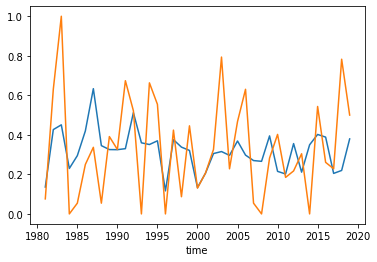

In [15]:
preds2.groupby(preds2.index.year).mean().plot()
y.groupby(y.index.year).mean().plot()

In [16]:
preds3 = fit_predict(model = m, X_in = X, y_in = y_tr, n_folds = 5)
preds3.index = preds3.index.droplevel('fold')
ret3 = evaluate(y_true = y_tr, y_pred=preds3, **evaluate_kwds)

In [17]:
ret3

score
bs    0.203719
dtype: float64

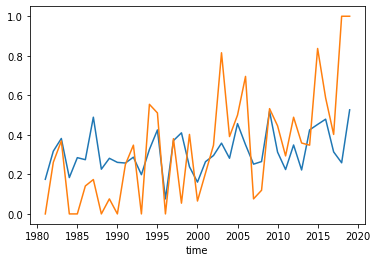

In [18]:
preds3.groupby(preds3.index.year).mean().plot()
y_tr.groupby(y_tr.index.year).mean().plot()

In [19]:
brier_score_clim(threshold)

0.22244399999999998

In [20]:
m2 = RandomForestClassifier(n_estimators=1500, n_jobs=20, min_samples_split=20, max_depth=15, max_features = 35)
preds4 = fit_predict(model = m2, X_in = X, y_in = y, n_folds = 5)
preds4.index = preds4.index.droplevel('fold')
ret4 = evaluate(y_true = y, y_pred=preds4, **evaluate_kwds)

In [21]:
ret4

score
bs    0.219331
dtype: float64

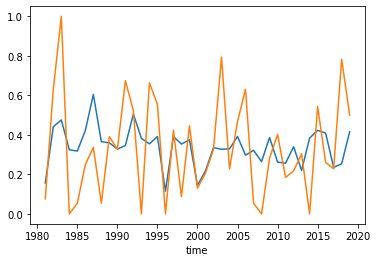

In [22]:
preds4.groupby(preds4.index.year).mean().plot()
y.groupby(y.index.year).mean().plot()

## Hybrid models
Dealing with the idea that perhaps relations are non-stationary (not all residuals are equal). So we need a 'climate change aware' forest, but also one that is not learning the trend (waste of learning resources). 
So something like gmst or co2 or years as an input.
Predicting trended data in the hybrid setting means that also a different baseline is needed.

In [7]:
timeframe = pd.DataFrame(scale(np.repeat(X.index.to_julian_date().values[:,np.newaxis], 5, axis = 1), axis = 0, with_mean = True, with_std = False), index = X.index, columns = pd.MultiIndex.from_product([list(range(5)),['year']] + [[None]] * 5, names = X.columns.names))
X_new = pd.concat([X,timeframe], axis = 1)

In [26]:
m2 = RandomForestClassifier(n_estimators=1500, n_jobs=20, min_samples_split=20, max_depth=15, max_features = 35)
preds5 = fit_predict(model = m2, X_in = X_new, y_in = y, n_folds = 5)
preds5.index = preds5.index.droplevel('fold')
ret5 = evaluate(y_true = y, y_pred=preds5, **evaluate_kwds)

In [27]:
ret5

score
bs    0.218915
dtype: float64

Conclusion from the above: 'time-aware' fitting does not really help.
We need to remove trend more intelligently. We fit a base model.

In [65]:
# Non-cv reference forecast of base model
lr4 = BaseExceedenceModel()
preds7 = fit_predict(model = lr4, X_in = X, y_in = y_tr, X_val = X, y_val = y_tr)
ret7 = evaluate(y_true = y_tr, y_pred=preds7, **evaluate_kwds)

In [66]:
ret7

score
bs    0.189779
dtype: float64

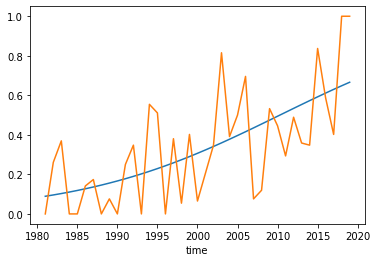

In [67]:
preds7.groupby(preds7.index.year).mean().plot()
y_tr.groupby(y_tr.index.year).mean().plot()

In [68]:
lr3 = BaseExceedenceModel()
preds6 = fit_predict(model = lr3, X_in = X, y_in = y_tr, n_folds = 5)
preds6.index = preds6.index.droplevel('fold')
ret6 = evaluate(y_true = y_tr, y_pred=preds6, **evaluate_kwds)

In [69]:
ret6

score
bs    0.193742
dtype: float64

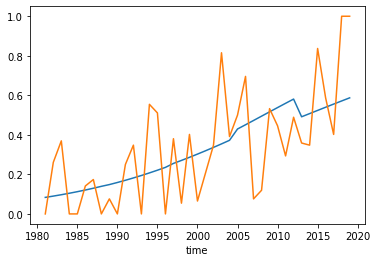

In [70]:
preds6.groupby(preds6.index.year).mean().plot()
y_tr.groupby(y_tr.index.year).mean().plot()

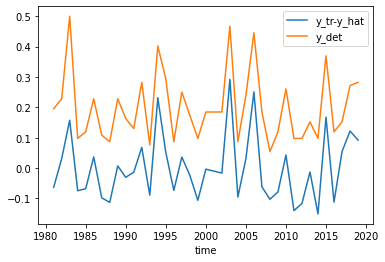

In [46]:
(y_tr - preds6).groupby(preds6.index.year).mean().plot(label = 'y_tr-y_hat')
y.groupby(y.index.year).mean().plot(label = 'y_det')
plt.legend()

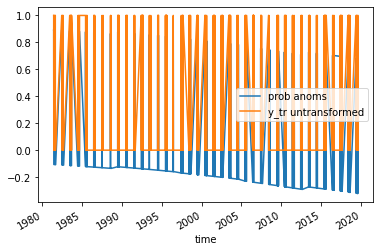

In [47]:
(y_tr - preds6).plot(label = 'prob anoms')
(y + 0.0).plot(label = 'y_tr untransformed')
plt.legend()

Text(0.5, 1.0, 'What the RF will train on')

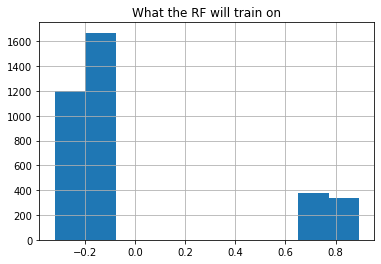

In [48]:
(y_tr - preds6).hist()
plt.title('What the RF will train on')

In [81]:
m4 = HybridExceedenceModel(n_estimators=1500, n_jobs=20, min_samples_split=40, max_depth=7, max_features = 35)
preds10 = fit_predict(model = m4, X_in = X, y_in = y_tr, n_folds = 5)
preds10.index = preds10.index.droplevel('fold')
ret10 = evaluate(y_true = y_tr, y_pred=preds10, **evaluate_kwds)

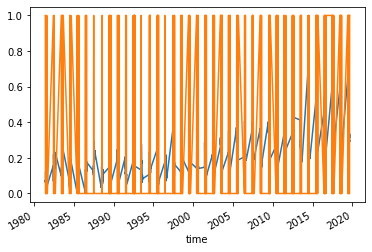

In [50]:
preds10.plot()
(y_tr + 0.0).plot()

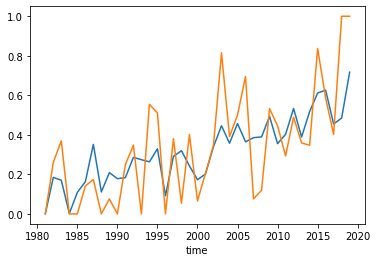

In [72]:
preds10.groupby(preds10.index.year).mean().plot()
y_tr.groupby(y_tr.index.year).mean().plot()

In [82]:
ret10

score
bs    0.193303
dtype: float64

In [74]:
m4

Hybrid combination with RandomForestRegressor(max_depth=7, max_features=35, min_samples_split=40,
                      n_estimators=1500, n_jobs=20) on top of LogisticRegression with scaled time index as only input: penalty=l2, C=1.0, fit_intercept=True

## Non-stationarity in input?

In [ ]:
X.loc[:,(3,'siconc_nhmin')].groupby(X.index.year).mean().plot(legend = False)

In [ ]:
X.loc[:,(3,'siconc_nhmin',slice(None),slice(None),slice(None),slice(None),'spatcov')].groupby(X.index.year).mean().plot(legend = False)

## Hyperparams of the trended basemodel?

In [28]:
hyperparams = dict(C = [1000.0, 10.0,5.0,1.0,0.7,0.5,0.3,0.001])
otherparams = dict(fit_intercept = True, penalty = 'l2')
ret = hyperparam_evaluation(model = BaseExceedenceModel, X_in = X, y_in = y_tr, hyperparams= hyperparams, other_kwds=otherparams, fit_predict_evaluate_kwds= dict(n_folds = 5, evaluate_kwds = evaluate_kwds))

In [ ]:
ret.groupby('score').mean()

The penalization here has hardly an influence. Only one predictor. Fit intercept is absolutely neccesary

## Resolution as a function of model depth
From hyperparam optimization it seems that the hybrid model has a preference (in terms of bs) for being less deep. How does that show in reliability/resolution. And how does that compare to the resolution already present in the trended baseline model.

In [6]:
respagg = 31
separation = -21
threshold = 0.666
Y_path = '/scistor/ivm/jsn295/clusters_cv_spearmanpar_varalpha_strict/response.multiagg.trended.parquet'
X_path = '/scistor/ivm/jsn295/clusters_cv_spearmanpar_varalpha_strict/precursor.multiagg.parquet'
y = pd.read_parquet(Y_path).loc[:,(slice(None),respagg,slice(None))].iloc[:,0] # Only summer
X = pd.read_parquet(X_path).loc[y.index, (slice(None),slice(None),slice(None),slice(None),separation,slice(None),slice(None))].dropna(axis = 0, how = 'any')
map_foldindex_to_groupedorder(X, n_folds = 5)
y = y.reindex(X.index)
y = y > threshold

In [7]:
models = dict(
    base = BaseExceedenceModel(),
    hybrid_3 = HybridExceedenceModel(max_depth = 3, min_samples_split = 30, n_jobs = 25, max_features = 35, n_estimators = 1500),
    hybrid_5 = HybridExceedenceModel(max_depth = 5, min_samples_split = 30, n_jobs = 25, max_features = 35, n_estimators = 1500),
    hybrid_7 = HybridExceedenceModel(max_depth = 7, min_samples_split = 30, n_jobs = 25, max_features = 35, n_estimators = 1500))

preds = dict()
for key, model in models.items():
    preds.update({key:fit_predict(model, X, y, n_folds = 5, split_on_year = True)})
preds = pd.DataFrame(preds)
preds.columns.set_names(['type'], inplace = True)
preds.index = preds.index.droplevel('fold')

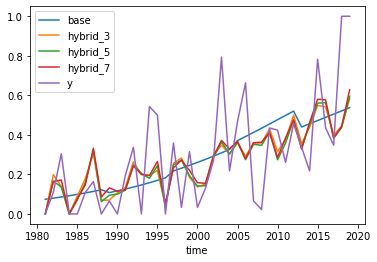

In [8]:
preds.groupby(preds.index.year).mean().plot()
y.groupby(y.index.year).mean().plot(label = 'y')
plt.legend()
plt.show()

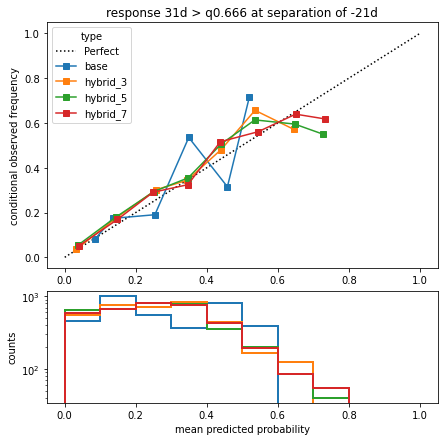

In [9]:
fig, axes = reliability_plot(y_true=y, y_probs = preds)
axes[0].set_title(f'response {respagg}d > q{threshold} at separation of {separation}d')
plt.show()

### Reliability as a function of timeagg
For one separation prove that predictability is not because of predictability of the first few days (Although the climate signal is less for the smaller timeaggs, variability is more challenging to handle). Lesson from previously.
For the chosen model of depth 5.

In [26]:
respaggs = [31,21,15,7]
separation = -15
threshold = 0.666
Y_path = '/scistor/ivm/jsn295/clusters_cv_spearmanpar_varalpha_strict/response.multiagg.trended.parquet'
X_path = '/scistor/ivm/jsn295/clusters_cv_spearmanpar_varalpha_strict/precursor.multiagg.parquet'

predsbase = dict()
preds = dict()
ys = dict()

for respagg in respaggs:
    y = pd.read_parquet(Y_path).loc[:,(slice(None),respagg,slice(None))].iloc[:,0] # Only summer
    X = pd.read_parquet(X_path).loc[y.index, (slice(None),slice(None),slice(None),slice(None),separation,slice(None),slice(None))].dropna(axis = 0, how = 'any')
    map_foldindex_to_groupedorder(X, n_folds = 5)
    y = y.reindex(X.index)
    y = y > threshold
    base = HybridExceedenceModel(fit_base_to_all_cv=True,base_only=True)
    model = HybridExceedenceModel(fit_base_to_all_cv=True,base_only=False, max_depth = 5, min_samples_split = 30, n_jobs = 25, max_features = 35, n_estimators = 2500)
    predsbase.update({respagg:fit_predict(base, X_in = X, y_in = y, X_val = X, y_val = y)})
    preds.update({respagg:fit_predict(model, X, y, n_folds = 5, split_on_year = True)})
    ys.update({respagg:y})

In [27]:
preds = pd.DataFrame(preds)
preds.columns.set_names(['respagg'], inplace = True)
preds.index = preds.index.droplevel('fold')
predsbase = pd.DataFrame(predsbase)
predsbase.columns.set_names(['respagg'], inplace = True)
ys = pd.DataFrame(ys)
ys.columns.set_names(['respagg'], inplace = True)

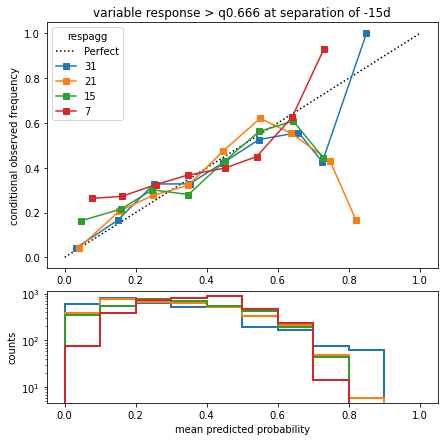

In [28]:
fig, axes = reliability_plot(y_true=ys, y_probs = preds)
axes[0].set_title(f'variable response > q{threshold} at separation of {separation}d')
plt.show()

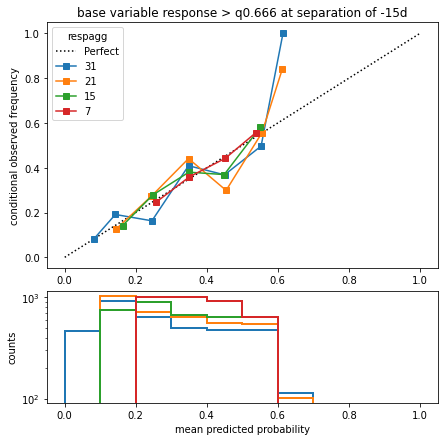

In [29]:
fig, axes = reliability_plot(y_true=ys, y_probs = predsbase)
axes[0].set_title(f'base variable response > q{threshold} at separation of {separation}d')
plt.show()

So a reliability diagram is not the most ideal way to show a greater sub-seasonal predictability of the long term variable relative to the short term variable, basically because the underlying predictability coming from the trend is larger. Still I think it is there, somewhat visible in the BSS (where the underlying baseline is varied).

## Logprob hybrid model test
Regression random forest in log-odds space.

In [2]:
respagg = 31
separation = -15
threshold = 0.666
Y_path = '/scistor/ivm/jsn295/clusters_cv_spearmanpar_varalpha_strict/response.multiagg.trended.parquet'
X_path = '/scistor/ivm/jsn295/clusters_cv_spearmanpar_varalpha_strict/precursor.multiagg.parquet'
y = pd.read_parquet(Y_path).loc[:,(slice(None),respagg,slice(None))].iloc[:,0] # Only summer
X = pd.read_parquet(X_path).loc[y.index, (slice(None),slice(None),slice(None),slice(None),separation,slice(None),slice(None))].dropna(axis = 0, how = 'any')
map_foldindex_to_groupedorder(X, n_folds = 5)
y = y.reindex(X.index)
y = y > threshold

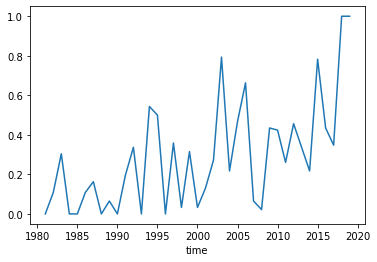

In [3]:
y.groupby(y.index.year).mean().plot()

In [6]:
logst = BaseExceedenceModel()
logst.fit(X = X, y = y)
logcl = logst.predict_log_proba(X = X)
target = y - logcl

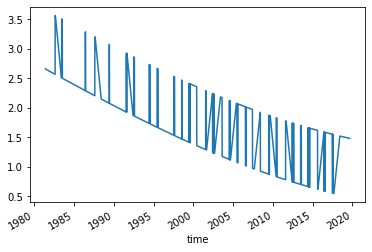

In [8]:
target.plot()

Target still has quite a trend in it. Not sure if this is going to work well.

In [19]:
rf = RandomForestRegressor(max_depth = 5, min_samples_split = 30, n_jobs = 25, max_features = 35, n_estimators = 1500)
preds = fit_predict(rf, X_in = X, y_in = target, n_folds=5)

In [21]:
preds.index = preds.index.droplevel('fold')

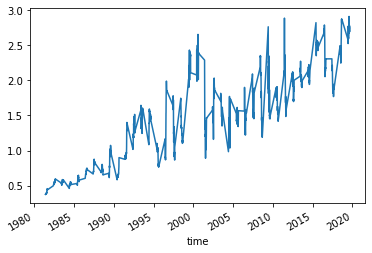

In [25]:
np.exp(preds + logcl).plot()

Not good. Actually less constrained than the other approach in which I just add probabilities.

## Quantile threshold model test

In [57]:
from statsmodels.regression.quantile_regression import QuantReg
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(copy = True, with_mean = True, with_std = True)

In [114]:
respagg = 31
separation = -15
threshold = 0.8
Y_path = '/scistor/ivm/jsn295/clusters_cv_spearmanpar_varalpha_strict/response.multiagg.trended.parquet'
X_path = '/scistor/ivm/jsn295/clusters_cv_spearmanpar_varalpha_strict/precursor.multiagg.parquet'
y = pd.read_parquet(Y_path).loc[:,(slice(None),respagg,slice(None))].iloc[:,0] # Only summer
X = pd.read_parquet(X_path).loc[y.index, (slice(None),slice(None),slice(None),slice(None),separation,slice(None),slice(None))].dropna(axis = 0, how = 'any')
map_foldindex_to_groupedorder(X, n_folds = 5)
y = y.reindex(X.index)

In [115]:
inp = pd.DataFrame({'date':scaler.fit_transform(X.index.to_julian_date().values[:,np.newaxis]).squeeze(), 'intercept':1}, index = y.index)
qr = QuantReg(endog =y[:,np.newaxis], exog = inp)

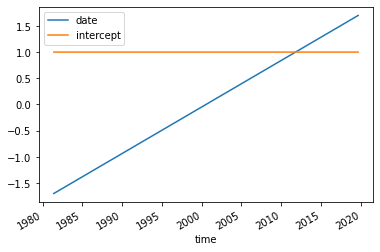

In [116]:
inp.plot()

In [117]:
ret = qr.fit(q = threshold)

/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [118]:
ret.params

date         0.481998
intercept    0.879271
dtype: float64

In [119]:
quant = inp['date'] * ret.params['date'] + inp['intercept'] * ret.params['intercept']

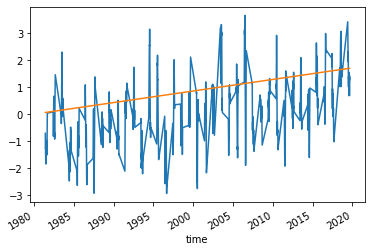

In [120]:
y.plot()
quant.plot()
plt.show()

In [121]:
target = y > quant

In [122]:
evaluate_kwds = dict(scores = [brier_score_loss], score_names = ['bs'])
m2 = RandomForestClassifier(n_estimators=1500, n_jobs=20, min_samples_split=30, max_depth=5, max_features = 35)
preds4 = fit_predict(model = m2, X_in = X, y_in = target, n_folds = 5)
preds4.index = preds4.index.droplevel('fold')
ret4 = evaluate(y_true = target, y_pred=preds4, **evaluate_kwds)

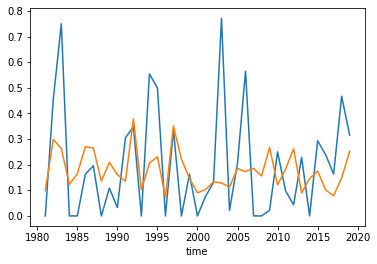

In [123]:
target.groupby(y.index.year).mean().plot()
preds4.groupby(y.index.year).mean().plot()
plt.show()

TypeError: sequence item 0: expected str instance, NoneType found

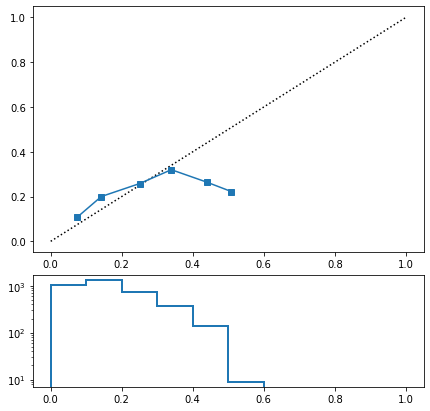

In [124]:
fig, axes = reliability_plot(y_true=target, y_probs = preds4)
axes[0].set_title(f'base variable response > q{threshold} at separation of {separation}d')
plt.show()

In [112]:
ret4

score
bs    0.217682
dtype: float64